In [1]:
import pandas as pd
import numpy as np
import MySQLdb as my
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups

import nltk
#nltk.download()
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import sys
#reload(sys)
#sys.setdefaultencoding('utf-8')

In [2]:
def load_db():
    fname="../dbcreds.dat" 
    f = open(fname,"r")
    #rstrip() is needde here or else it includse the newline from the creds file
    dbhost = f.readline().split(' ')[1].rstrip()
    dbuser = f.readline().split(' ')[1].rstrip()
    dbpw = f.readline().split(' ')[1].rstrip()
    dbdb = f.readline().split(' ')[1].rstrip()
    f.close()

    db = my.connect(host=dbhost,
            user=dbuser,
            passwd=dbpw,
            db=dbdb,
           #use_unicode=True, 
           # charset="utf8"
            )
    return db

In [3]:
# Over Single Month Period (30 days)
db = load_db()
cursor = db.cursor()
#date_from = '\'2018-01-31\''
#date_to = '\'2018-02-31\'' 
# Fix this naming
#sql = 'select lower(blurb),date from article_url where date <= ' +  date_to   + ' and >= ' + date_from
sql = 'select lower(blurb),date from article_url where date <=  "2018-03-31"  and date >= "2018-02-31"     '
cursor.execute(sql)
blurb_date_list = list(cursor.fetchall())

db.close()

In [4]:
#df = pd.read_sql('select lower(blurb),date from article_url where date = "2018-01-01"', con=db)
#for blurb,date in blurb_date_list:
    

In [5]:
#print df

In [6]:
date_freq = {}
target = 'trump'
for blurb,date in blurb_date_list:
    if target in blurb:
        if date in date_freq:
            date_freq[date] += 1
        else:
            date_freq[date] = 0
#rint date_freq

In [7]:
# https://stackoverflow.com/questions/17839973/constructing-pandas-dataframe-from-values-in-variables-gives-valueerror-if-usi
# Avoiding 'ValueError: If using all scalar values, you must pass an index' error
# Need to do reset index based on this in order to assign new column names we can pass into seaborn later 
# https://stackoverflow.com/questions/28503445/assigning-column-names-to-a-pandas-series
trump_df = pd.Series(date_freq).to_frame().reset_index()
trump_df.columns = ['date','freq']
#print trump_df

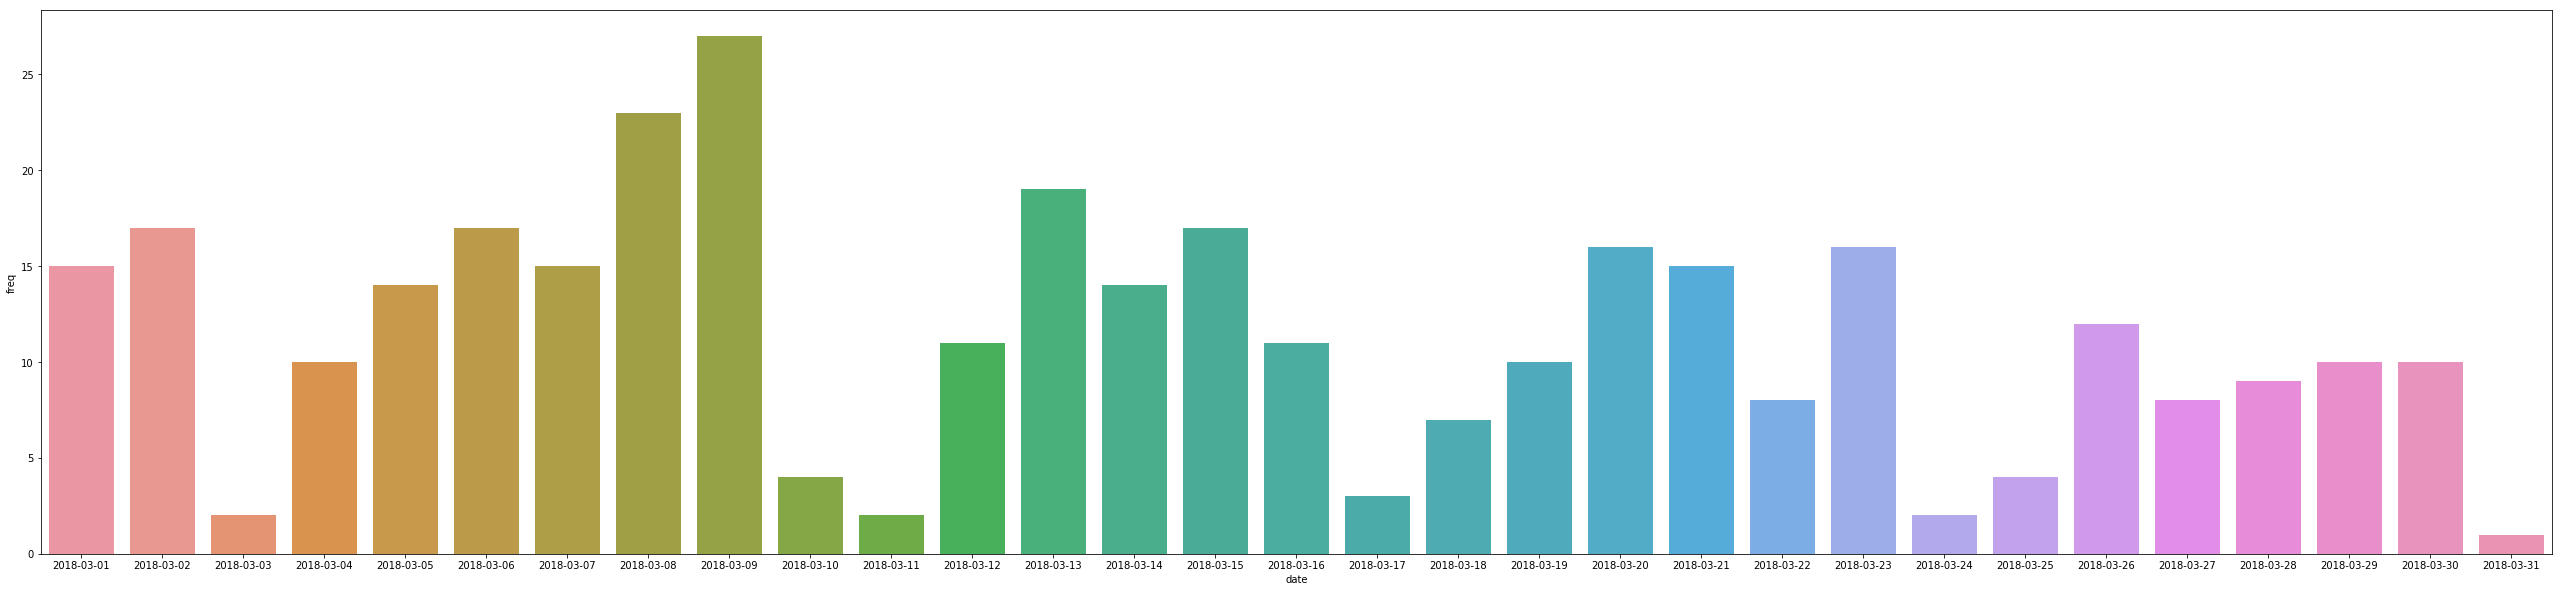

In [8]:
plt.figure(figsize=(45,10))
ax = sns.barplot(x="date", y="freq", data=trump_df)
#plt.savefig('2_trump_freq.pdf')

In [9]:
#Over Entire Year

db = load_db()
cursor = db.cursor()
sql = 'select lower(blurb),date from article_url'
cursor.execute(sql)
blurb_date_list = list(cursor.fetchall())
db.close()

In [88]:
date_freq = {}
target = 'china'
for blurb,date in blurb_date_list:
    if target in blurb:
        if date.month in date_freq:
            date_freq[date.month] += 1
        else:
            date_freq[date.month] = 0
#rint date_freq

In [89]:
# https://stackoverflow.com/questions/17839973/constructing-pandas-dataframe-from-values-in-variables-gives-valueerror-if-usi
# Avoiding 'ValueError: If using all scalar values, you must pass an index' error
# Need to do reset index based on this in order to assign new column names we can pass into seaborn later 
# https://stackoverflow.com/questions/28503445/assigning-column-names-to-a-pandas-series
trump_df = pd.Series(date_freq).to_frame().reset_index()
trump_df.columns = ['month','freq']
#print trump_df

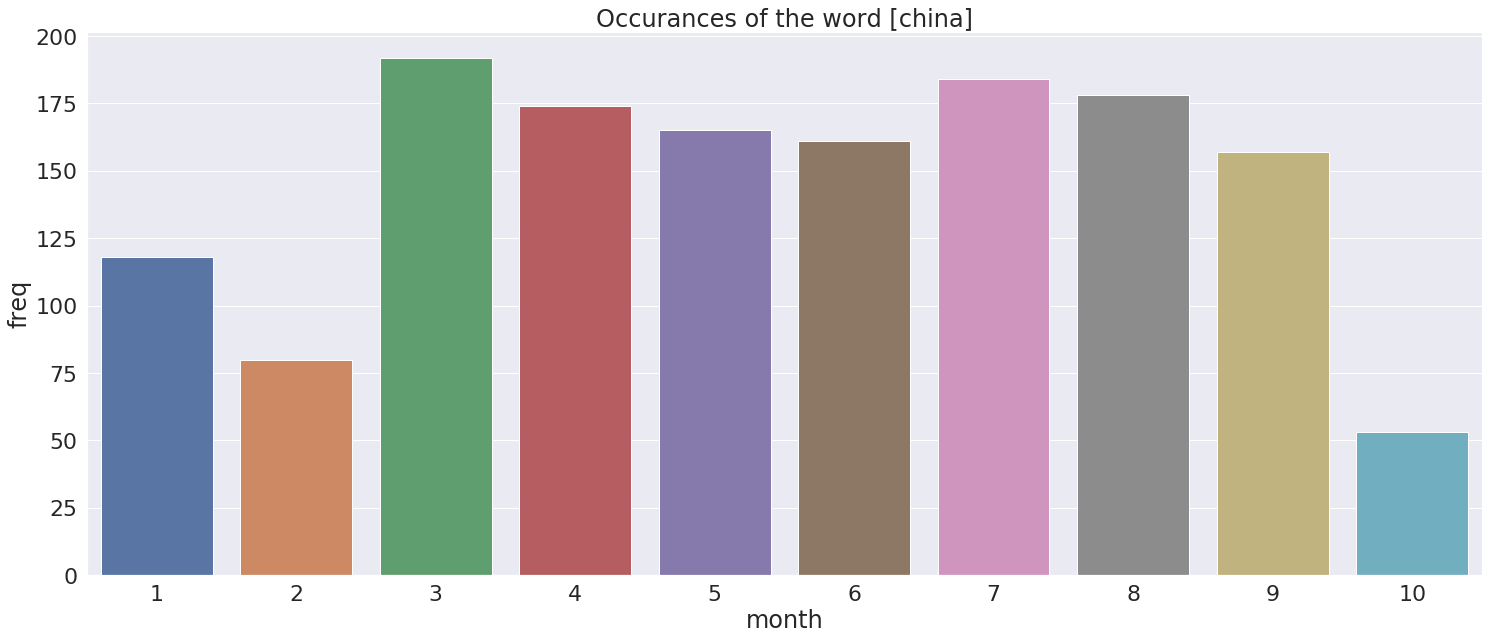

In [90]:
plt.figure(figsize=(25,10))
sns.set(font_scale = 2)
ax = sns.barplot(x="month", y="freq", data=trump_df).set_title('Occurances of the word [' + target + ']')
plt.savefig('../results/' + target + '_year_freq.pdf')

## Word2Vec 

In [13]:
blurb_list = []
for blurb,date in blurb_date_list:
    blurb_list.append(blurb)

In [14]:
def clean(text):
    """Remove posting header, split by sentences and words, keep only letters"""
    lines = re.split('[?!.:]\s', re.sub('^.*Lines: \d+', '', re.sub('\n', ' ', text)))
    return [re.sub('[^a-zA-Z]', ' ', line).lower().split() for line in lines]


In [16]:
sentences = [line for text in blurb_list for line in clean(text)]

In [17]:
model = Word2Vec(sentences, workers=4, size=100, min_count=50, window=10, sample=1e-3)

In [57]:
print (model.wv.most_similar('trump'))

[('xi', 0.5965028405189514), ('jinping', 0.5771353840827942), ('obama', 0.5718263387680054), ('macron', 0.5675344467163086), ('donald', 0.5437671542167664), ('impose', 0.516465961933136), ('erdogan', 0.4960069954395294), ('vladimir', 0.491290807723999), ('vice', 0.4716377854347229), ('putin', 0.47028157114982605)]


In [43]:
#TODO(shelbyt): For some reason this always shows a different graph.
X = model.wv[model.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

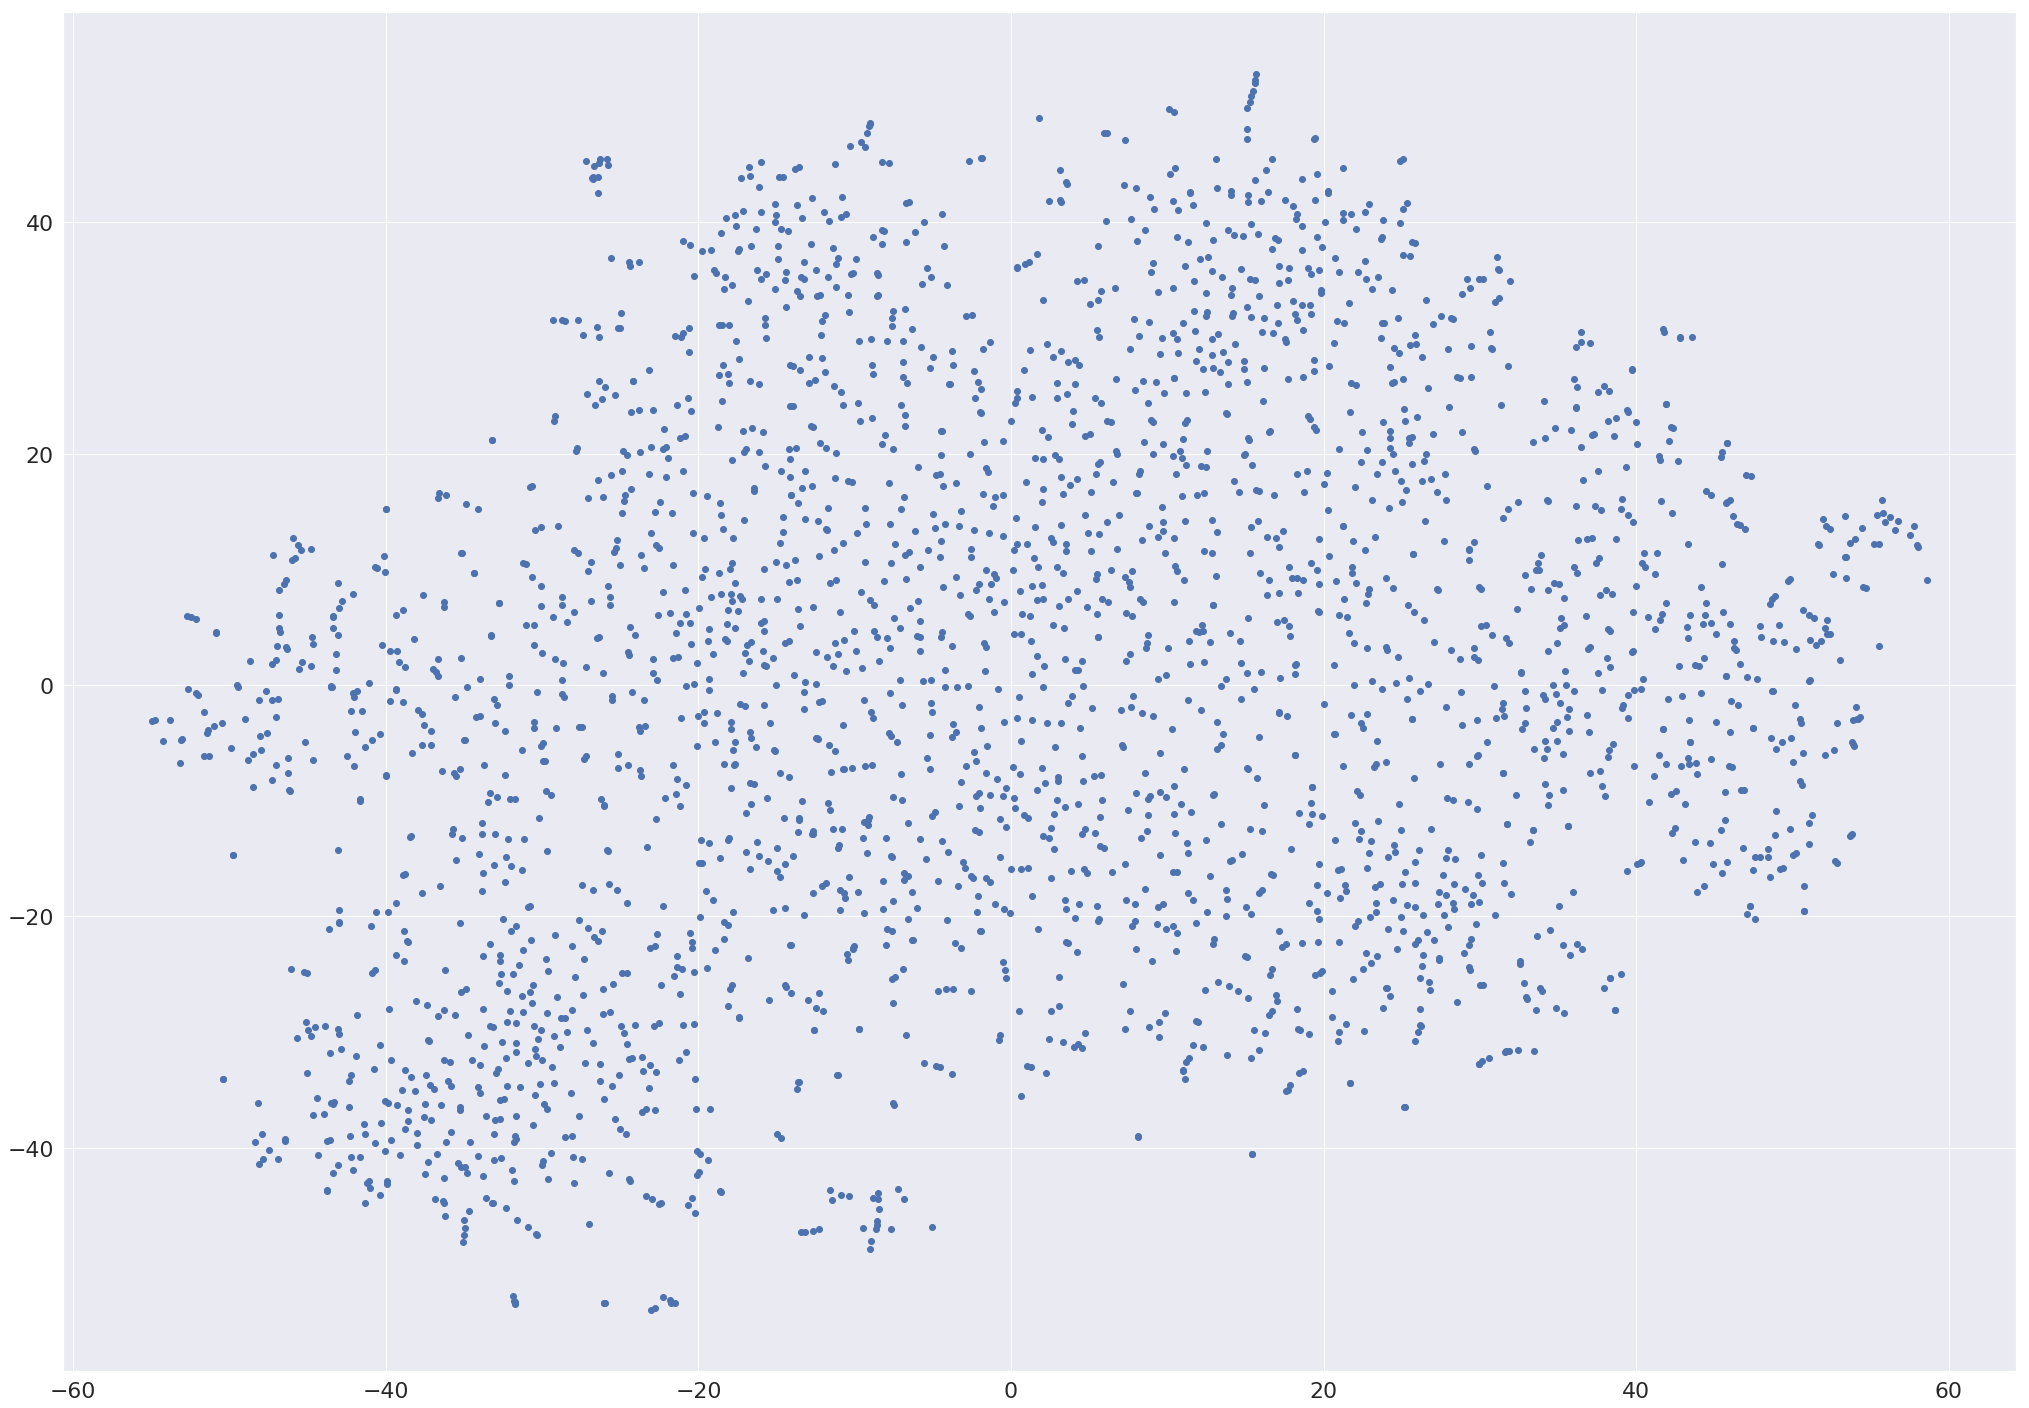

In [47]:
plt.figure(figsize=(35,25))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

## Use word2phrase to find phrases i.e. ['xi_jinping'] instead of ['xi','jinping']

In [130]:
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser
import gensim

In [138]:
# To create bigram phrase list we can actually use the ENTIRE corpus. Over any amount of years
#TODO(shelbyt): We should honestly generate a phrase list from a much much larger corpus such as Google News etc.
blurb_list = []
for blurb,date in blurb_date_list:
    # Need to do this to remove all special characters. ALready loweored cased because 
    # we did that when we extracted from the database
    blurb = re.sub('[^A-Za-z0-9 ]+', '', blurb)
    blurb_list.append(blurb)
# Need to convert blurb_list into a list of word lists

sentence_stream=[doc.split(" ") for doc in blurb_list]
#print sentence_stream
#sentences = Text8Corpus(datapath('testcorpus.txt'))
phrases = Phrases(sentence_stream, min_count=1, threshold=2)  # train model

In [140]:
# Test Model
sent = [u'the', u'mayor', u'of', u'xi', u'jinping', u'was', u'there']
print(phrases[sent])

[u'thasdfasfasfssfsde', u'mayor', u'of', u'xi_jinping', u'was', u'there']


In [114]:
#sentences = [phrases[text] for text in blurb_list for line in clean(text)]
#sentences = [phrases[text] for text in blurb_list]
sentences = [line for text in blurb_list for line in clean(text)]

In [108]:
model = Word2Vec(sentences, workers=4, size=100, min_count=50, window=10, sample=1e-3)

In [109]:
print (model.wv.most_similar('india'))

KeyError: "word 'india' not in vocabulary"

[' 100',
 '10000 miles along the yangzi river review a river journey in the gallery wang huis lengthy handscroll casts nature as the protagonist while stirring emotions and evoking poetry earlier paintings history and cultural references',
 '10 billion jfk airport renovation doesnt include a new runway a 10 billion facelift at john f kennedy international airport wont include one element that planners say is essential to handling rising demand in coming decades a new runway',
 '10 burning questions about cologne answered mens fashion editor jacob gallagher takes on questions both practical and whimsical about the most evanescent element of style',
 '10 decorators best and worst buys design professionals reveal the smartest dcor purchases theyve ever made midcentury finds on craigslist and the most regrettable a stinky ottoman what you can learn from their admissions',
 '10 new york city towtruck firms indicted manhattan prosecutors accused 17 people and 10 companies of using fraud and 

[[],
 ['miles',
  'along',
  'the',
  'yangzi',
  'river',
  'review',
  'a',
  'river',
  'journey',
  'in',
  'the',
  'gallery',
  'wang',
  'huis',
  'lengthy',
  'handscroll',
  'casts',
  'nature',
  'as',
  'the',
  'protagonist',
  'while',
  'stirring',
  'emotions',
  'and',
  'evoking',
  'poetry',
  'earlier',
  'paintings',
  'history',
  'and',
  'cultural',
  'references'],
 ['billion',
  'jfk',
  'airport',
  'renovation',
  'doesnt',
  'include',
  'a',
  'new',
  'runway',
  'a',
  'billion',
  'facelift',
  'at',
  'john',
  'f',
  'kennedy',
  'international',
  'airport',
  'wont',
  'include',
  'one',
  'element',
  'that',
  'planners',
  'say',
  'is',
  'essential',
  'to',
  'handling',
  'rising',
  'demand',
  'in',
  'coming',
  'decades',
  'a',
  'new',
  'runway'],
 ['burning',
  'questions',
  'about',
  'cologne',
  'answered',
  'mens',
  'fashion',
  'editor',
  'jacob',
  'gallagher',
  'takes',
  'on',
  'questions',
  'both',
  'practical',
  'an

In [123]:
# TODO(shelbyt): Unoptimzed, bad implementation.
def phrase_clean(text,phrase_bigram):
    """Remove posting header, split by sentences and words, keep only letters"""
    lines = re.split('[?!.:]\s', re.sub('^.*Lines: \d+', '', re.sub('\n', ' ', text)))
    split_lines = [re.sub('[^a-zA-Z]', ' ', line).lower().split() for line in lines]
    return phrase_bigram[split_lines]

In [124]:
sentences = [line for text in blurb_list for line in phrase_clean(text,phrases)]

In [126]:
model = Word2Vec(sentences, workers=4, size=100, min_count=50, window=10, sample=1e-3)

In [128]:
print (model.wv.most_similar('china'))

[(u'trade', 0.9149413108825684), (u'and_china', 0.9110234975814819), (u'us', 0.9079040288925171), (u'between_the', 0.9052166938781738), (u'the_us', 0.8819884061813354), (u'beijing', 0.8819264769554138), (u'trade_war', 0.8602464199066162), (u'tariffs', 0.8559389710426331), (u'the_dollar', 0.8543264269828796), (u'trade_tensions', 0.8532133102416992)]


## This is better BUT we need to have a better phrase corpus

In [137]:
#model = gensim.models.KeyedVectors.load_word2vec_format('../word2vec-slim/GoogleNews-vectors-negative300-SLIM.bin', binary=True)

In [141]:
from nltk.corpus import stopwords

In [144]:
# To create bigram phrase list we can actually use the ENTIRE corpus. Over any amount of years
#TODO(shelbyt): We should honestly generate a phrase list from a much much larger corpus such as Google News etc.
blurb_list = []
print "starting"
for blurb,date in blurb_date_list:
    # Need to do this to remove all special characters. ALready loweored cased because 
    # we did that when we extracted from the database
    blurb = re.sub('[^A-Za-z0-9 ]+', '', blurb)
    # Remove all stopwords. TODO(shelbyt): Optimize
    blurb = ' '.join(w for w in blurb.split() if w not in stopwords.words('english'))
    blurb_list.append(blurb)
    if len(blurb_list)%10000 == 0:
        print "1000 done"
# Need to convert blurb_list into a list of word lists
# Takes about 10 minutes


starting
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done
1000 done


In [145]:
sentence_stream=[doc.split(" ") for doc in blurb_list]
#print sentence_stream
#sentences = Text8Corpus(datapath('testcorpus.txt'))
phrases = Phrases(sentence_stream, min_count=1, threshold=2)  # train model

In [147]:
# Test Model
sent = [u'the', u'mayor', u'of', u'xi', u'jinping', u'was', u'there']
print(phrases[sent])

[u'the', u'mayor', u'of', u'xi_jinping', u'was', u'there']


In [148]:
# TODO(shelbyt): Unoptimzed, bad implementation.
def phrase_clean(text,phrase_bigram):
    """Remove posting header, split by sentences and words, keep only letters"""
    lines = re.split('[?!.:]\s', re.sub('^.*Lines: \d+', '', re.sub('\n', ' ', text)))
    split_lines = [re.sub('[^a-zA-Z]', ' ', line).lower().split() for line in lines]
    return phrase_bigram[split_lines]

In [149]:
sentences = [line for text in blurb_list for line in phrase_clean(text,phrases)]

In [150]:
model = Word2Vec(sentences, workers=4, size=100, min_count=50, window=10, sample=1e-3)

In [156]:
print (model.wv.most_similar('india'))

[(u'compete', 0.998085618019104), (u'protest', 0.9976372718811035), (u'remains', 0.9973911046981812), (u'london', 0.9972495436668396), (u'indonesia', 0.9971969723701477), (u'mark', 0.996978759765625), (u'festival', 0.9968357682228088), (u'near', 0.996531069278717), (u'german', 0.9963858723640442), (u'son', 0.9963199496269226)]
